<a href="https://colab.research.google.com/github/JoshWilbur/American-Sign-Language-D.L.-Model/blob/main/ECE_491_Final_Project_ASL_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Authors**: Joshua Wilbur, Amir Seidakhmetov

This notebook covers the preprocessing, design and testing of a fine tuned convolutional neural network. This model specializing in identifying hand gestures in American Sign Language (ASL). All of the work seen below is our own, some of which is taken from our prior assignments in ECE 491. The datasets used are linked below.

**Dataset links:**
* Training dataset: https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/data
* New dataset to test overfitting: https://www.kaggle.com/datasets/danrasband/asl-alphabet-test/data




# Prepare Dataset and Libraries

Upload a kaggle.json API token to download the database. We used this link to help get this set up: https://stackoverflow.com/questions/74037120/how-to-download-kaggle-dataset

In [1]:
from google.colab import files
import os

# Upload Kaggle API key
uploaded = files.upload()

# Create the .kaggle directory to store token
!mkdir -p /root/.kaggle

# Variable to hold file, move key file to kaggle directory
key_file_name = "kaggle.json"
key_path = os.path.join("/root/.kaggle/", key_file_name)
!mv $key_file_name $key_path

# Set permissions for the key file
!chmod 600 $key_path

# Download dataset
!kaggle datasets download -d debashishsau/aslamerican-sign-language-aplhabet-dataset -p /content/dataset

# Unzip dataset
!unzip -q /content/dataset/aslamerican-sign-language-aplhabet-dataset.zip -d /content/dataset

Saving kaggle.json to kaggle.json
100% 4.20G/4.20G [03:33<00:00, 21.2MB/s]
100% 4.20G/4.20G [03:33<00:00, 21.1MB/s]


Import libraries

In [2]:
# Install split-folders for easy splitting of training and validation data
!pip install split-folders

# Import statements and installs
import zipfile
import numpy as np
import random as ran
import splitfolders

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, applications, Model
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

The splitfolders library is used to split the downloaded dataset into training and validation data. An 80/20 split between training and validation data is used.

In [3]:
# String to hold database directory path
database_dir =  "/content/dataset/ASL_Alphabet_Dataset"
total_data = os.path.join(database_dir, "asl_alphabet_train")

# Data that is split will be moved into this directory
split_data = os.path.join(database_dir, "asl_alphabet_split")

# Use splitfolder function to split data into training and validation
splitfolders.ratio(total_data, output=split_data, seed=42, ratio=(0.8,0.2))

# Analyze directory to confirm it split correctly
training_data = os.path.join(split_data, "train")
validation_data = os.path.join(split_data, "val")
print("\nTraining data: ", os.listdir(training_data))
print("Testing data: ", os.listdir(validation_data))
print("Number of catagories in training data: ", len(os.listdir(training_data)))
print("Number of catagories in validation data: ", len(os.listdir(validation_data)))

Copying files: 223074 files [01:59, 1862.80 files/s]


Training data:  ['T', 'R', 'W', 'G', 'Y', 'M', 'U', 'B', 'Q', 'D', 'V', 'J', 'I', 'space', 'A', 'X', 'C', 'F', 'nothing', 'P', 'Z', 'S', 'O', 'E', 'N', 'L', 'H', 'K', 'del']
Testing data:  ['T', 'R', 'W', 'G', 'Y', 'M', 'U', 'B', 'Q', 'D', 'V', 'J', 'I', 'space', 'A', 'X', 'C', 'F', 'nothing', 'P', 'Z', 'S', 'O', 'E', 'N', 'L', 'H', 'K', 'del']
Number of catagories in training data:  29
Number of catagories in validation data:  29


Plot random examples from the training dataset.

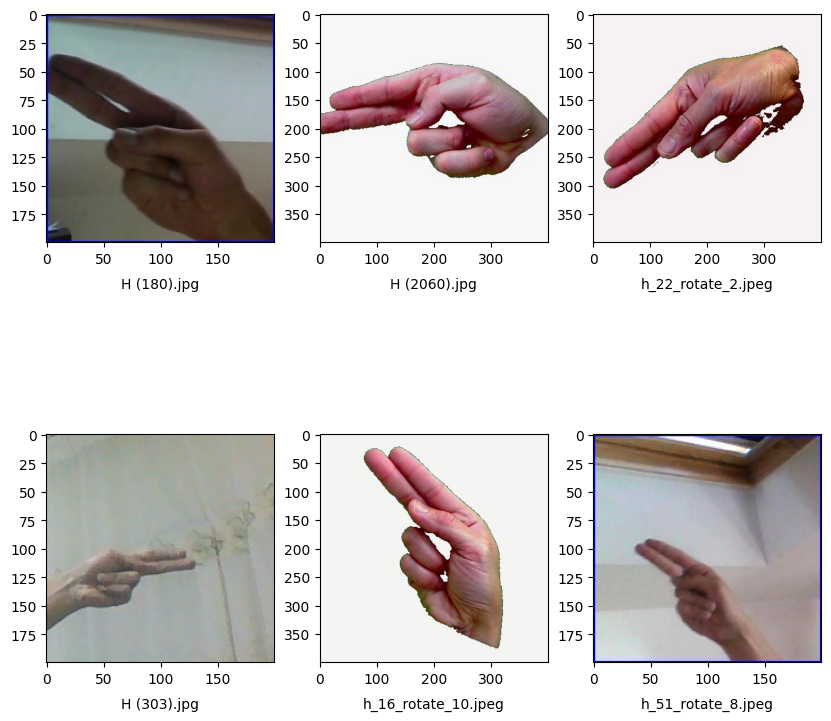

In [4]:
# Move into a random subdirectory within the training directory
dir =  "/content/dataset/ASL_Alphabet_Dataset/asl_alphabet_split/train/{rand_letter}".format(rand_letter = chr(ran.randint(ord('A'), ord('Z'))))
dir_fnames = os.listdir(dir)

# Pick 6 images from the above directory and plot
pic_index_train = ran.randint(3, 7000)
next_pix = [os.path.join(dir, fname) for fname in dir_fnames[pic_index_train-6:pic_index_train]]
fig = plt.gcf()
fig.set_size_inches(10, 10)

for i, img_path in enumerate(next_pix):
  sp = plt.subplot(2, 3, i + 1)
  fname = img_path
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.text(0.5, -0.2, dir_fnames[pic_index_train-i], ha='center', transform=plt.gca().transAxes)

plt.show()
print(img.shape)

Set up training and testing datasets to be fed into CNN using ImageDataGenerator. Had to be careful when augmenting data as different hand signs may look similar when image is flipped or rotated. Hyperparameter variables are created to help make tweaking the datasets easier.

In [5]:
# Hyperparameters
image_width = 200;
image_height = 200;
batch_size = 64;

# Add data augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2)

# Don't augment validation data
validation_datagen = ImageDataGenerator()

# Create training image generator
train_generator = train_datagen.flow_from_directory(
        training_data, # This is the source directory for training images
        target_size=(image_width, image_height),  # All images will be resized to 200, 200
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
print("Number of training batches: ", len(train_generator))


# Create validation image generator
validation_generator = validation_datagen.flow_from_directory(
        validation_data,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='categorical')
print("Number of validation batches: ", len(validation_generator))

(200, 200, 3)
Found 178447 images belonging to 29 classes.
Number of training batches:  2789
Found 44627 images belonging to 29 classes.
Number of validation batches:  698


# Build and Train Model

Our model is built below. After testing various other imported models, such as EfficientNetV2S and ResNet, we found VGG19 performed the best for fine tuning.

In [6]:
# Import VGG19 base model from Keras using pre-trained weights from ImageNet
imported_model = tf.keras.applications.VGG19(input_shape=(image_width, image_height, 3), weights='imagenet', include_top=False)

# Make existing model non-trainable to a certain point
for layer in imported_model.layers:
  layer.trainable = False

# Begin fine tuning at the output layer of VGG19 for feature extraction, then flatten to one dimension
x = imported_model.output
x = layers.Flatten()(x)

# Add batch normalization
x = layers.BatchNormalization()(x)

# Add a fully connected layer with 512 hidden units, ReLU activation and L2 bias regularization
x = layers.Dense(512, activation='relu', bias_regularizer=l1(0.02))(x)

# Add batch normalization
x = layers.BatchNormalization()(x)

# Add dropout layer with 40% dropout
x = layers.Dropout(0.4)(x)

# Add a fully connected layer with 256 hidden units, ReLU activation and L2 bias regularization
x = layers.Dense(256, activation='relu', bias_regularizer=l1(0.02))(x)

# Add a final softmax layer for multi-class classification
output = layers.Dense(29, activation='softmax')(x)

# Configure and compile the model
model = Model(imported_model.input, output)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0014),
              metrics=['accuracy'])
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

Train the model and save the best weights

In [7]:
# Hyperparameters for model training
steps = 64
epochs = 40

# Save best model
save_model_path = '/tmp/weights.hdf5'
best_model = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='max', save_best_only=True)

# Begin training the model
history = model.fit(train_generator, steps_per_epoch=steps, epochs=epochs, validation_data=validation_generator, validation_steps=steps, verbose=1,  callbacks=best_model)

Epoch 1/40
64/64 [==============================] - ETA: 0s - loss: 1.9327 - accuracy: 0.4856

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 105s 1s/step - loss: 1.9327 - accuracy: 0.4856 - val_loss: 1.4910 - val_accuracy: 0.6770
Epoch 2/40
64/64 [==============================] - 69s 1s/step - loss: 0.8250 - accuracy: 0.7588 - val_loss: 0.6065 - val_accuracy: 0.8264
Epoch 3/40
64/64 [==============================] - 69s 1s/step - loss: 0.5851 - accuracy: 0.8223 - val_loss: 0.3832 - val_accuracy: 0.8853
Epoch 4/40
64/64 [==============================] - 70s 1s/step - loss: 0.4963 - accuracy: 0.8450 - val_loss: 0.2944 - val_accuracy: 0.9116
Epoch 5/40
64/64 [==============================] - 70s 1s/step - loss: 0.4165 - accuracy: 0.8689 - val_loss: 0.2705 - val_accuracy: 0.9248
Epoch 6/40
64/64 [==============================] - 68s 1s/step - loss: 0.3791 - accuracy: 0.8818 - val_loss: 0.2760 - val_accuracy: 0.9187
Epoch 7/40
64/64 [==============================] - 68s 1s/step - loss: 0.3609 - accuracy: 0.8872 - val_loss: 0.2406 - val_accuracy: 0.9285
Epoch 8/40
64/64 [============

Plot out loss and accuracy statistics for our model.

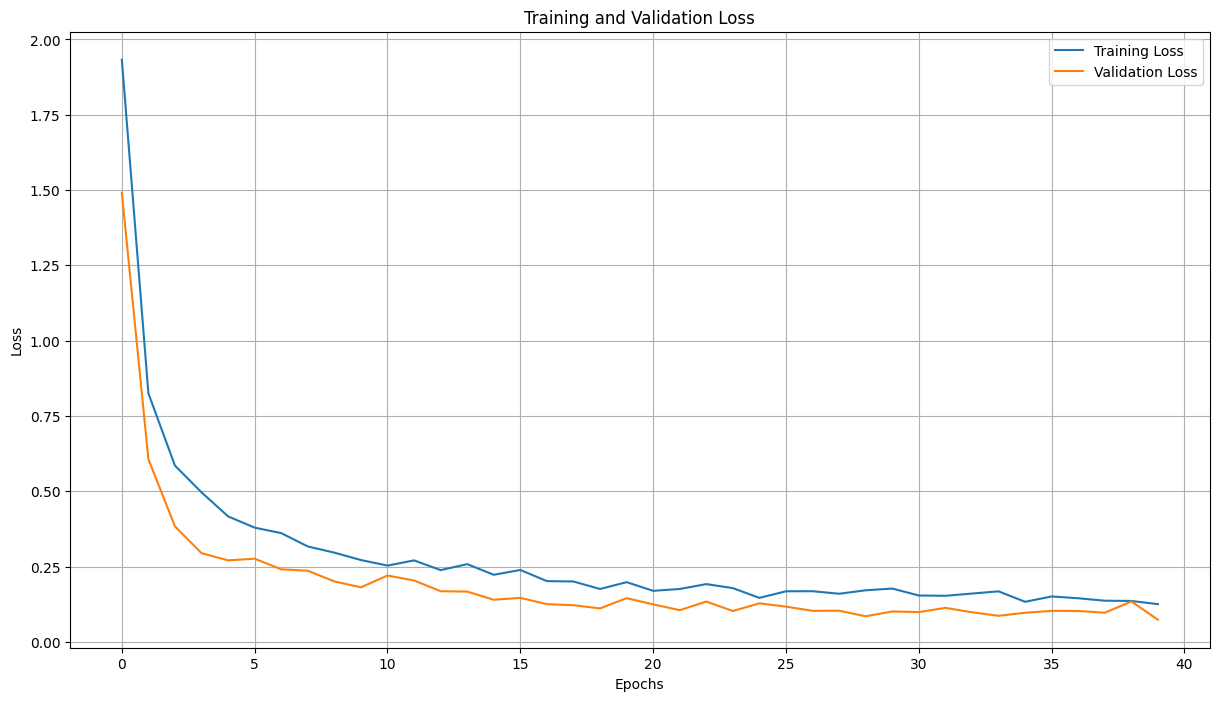

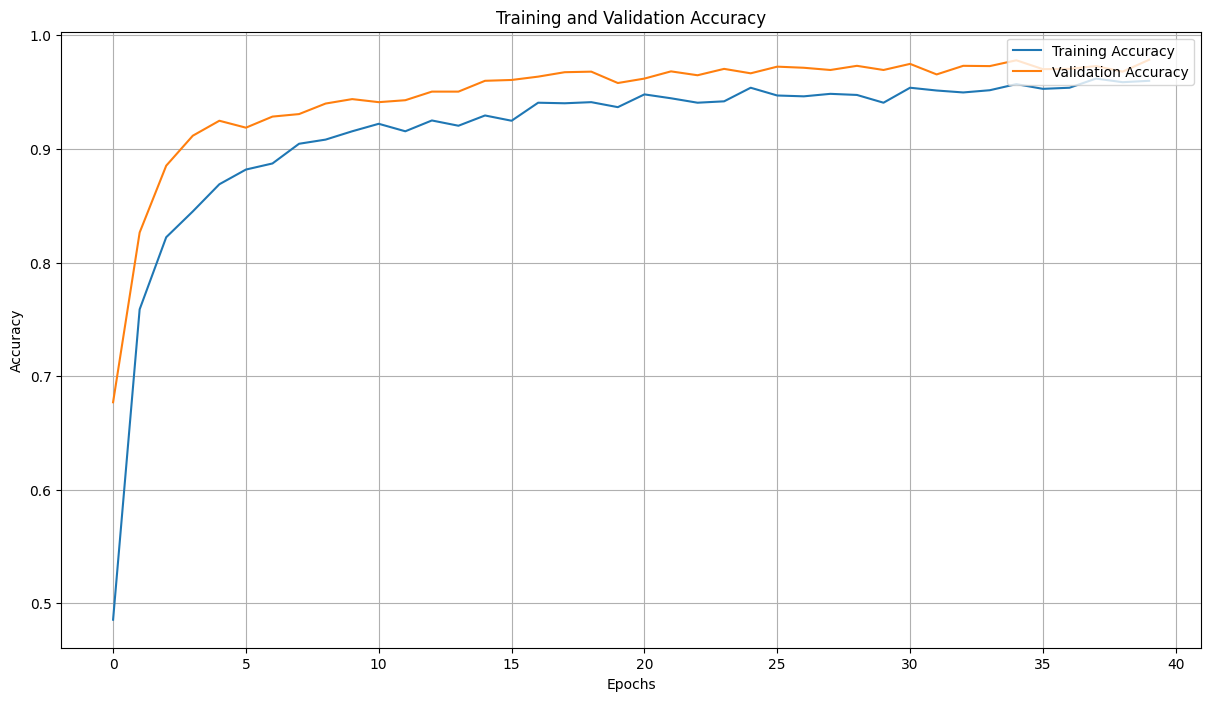

In [8]:
# Obtain statistics from training history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(0, len(loss))

# Plot comparison of training and validation loss
plt.figure(figsize=(50, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

# Plot comparison of training and validation accuracy
plt.figure(figsize=(50, 8))
plt.subplot(1, 3, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

plt.show()

# Test Model Using New Dataset

Now, the model will be tested using a new dataset to see if overfitting is a concern. The Kaggle API key from the first code block should still be valid to download.

In [9]:
# Download new dataset, store in new directory
!kaggle datasets download -d danrasband/asl-alphabet-test -p /content/test_dataset

# Unzip dataset
!unzip -q /content/test_dataset/asl-alphabet-test.zip -d /content/test_dataset/

 91% 22.0M/24.3M [00:02<00:00, 16.8MB/s]
100% 24.3M/24.3M [00:02<00:00, 11.5MB/s]


Since the new database is only intended for testing and the model is already trained, only a testing dataset is made using ImageDataGenerator.

In [10]:
# Create variable for test dataset path
testing_data =  '/content/test_dataset/asl-alphabet-test'

# Don't augment test data
test_datagen = ImageDataGenerator()

# Flow testing images using test_datagen generator, same hyperparameters as above
test_generator = test_datagen.flow_from_directory(
        testing_data,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

print("Testing data: ", os.listdir(testing_data))
print("Number of catagories in testing data: ", len(os.listdir(testing_data)))
print("Number of validation batches: ", len(test_generator))

Found 870 images belonging to 29 classes.
Testing data:  ['T', 'R', 'W', 'G', 'Y', 'M', 'U', 'B', 'Q', 'D', 'V', 'J', 'I', 'space', 'A', 'X', 'C', 'F', 'nothing', 'P', 'Z', 'S', 'O', 'E', 'N', 'L', 'H', 'K', 'del']
Number of catagories in testing data:  29
Number of validation batches:  14


Test model for a few epochs to see if overfitting occured in training. The testing dataset is used as validation in this case, so testing accuracy is validation accuracy.

In [11]:
new_history = model.fit(train_generator, steps_per_epoch=steps, epochs=5, validation_data=test_generator, validation_steps=14, verbose=1)

Epoch 1/5
64/64 [==============================] - 59s 916ms/step - loss: 0.1240 - accuracy: 0.9587 - val_loss: 1.2934 - val_accuracy: 0.7276
Epoch 2/5
64/64 [==============================] - 54s 836ms/step - loss: 0.1508 - accuracy: 0.9529 - val_loss: 1.3444 - val_accuracy: 0.7345
Epoch 3/5
64/64 [==============================] - 52s 812ms/step - loss: 0.1389 - accuracy: 0.9551 - val_loss: 1.1890 - val_accuracy: 0.7471
Epoch 4/5
64/64 [==============================] - 52s 812ms/step - loss: 0.1169 - accuracy: 0.9622 - val_loss: 1.1378 - val_accuracy: 0.7437
Epoch 5/5
64/64 [==============================] - 53s 830ms/step - loss: 0.1188 - accuracy: 0.9646 - val_loss: 1.0342 - val_accuracy: 0.7701
